# **Toxic Comment Classification Challenge**

### ***1. Descripcion del problema***

 *Em várias plataformas de mídia social, as seçães de comentários permitem que os usuários
 compartilhem ideias e discutam diferentes pontos de vista. No entanto, há um abuso
 de linguagem tóxica, especialmente no X (antigo Twitter), que não tem regras rígidas
 para regular esse tipo de comentário, o que está afetando a qualidade dessas conversas.
 Comentários que incluem ameaças, insultos, linguagem vulgar ou ódio contra certos gru
 pos sociais, dificultando um diálogo saudável.* 

### ***2. Análise descritiva de cada atributo***

### Carregar dados

In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from textstat import flesch_reading_ease
import warnings
warnings.filterwarnings("ignore")

# Adicional para BERTopic
from bertopic import BERTopic
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Carregando os dados
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### **a) Identificar os tipos de atributos**

A identificação dos tipos de atributos consiste em classificar cada coluna do dataset conforme sua natureza: **nominal**, **ordinal**, **binário**, **contínuo** ou **discreto**.

<center>

| Coluna | Tipo de Atributo | Descrição |
|-----------|-----------|---------------|
| id | Categórico nominai | Identificador único. <br>Não tem ordem nem significado além de identificar a fila |
| comment_text | Categórico nominai | Texto livre que contém o comentário a classificar.<br>Não team hierarquia nem ordem |
| toxic <br> severe_toxic <br> obscene <br> threat <br> insult<br> identity_hate| Binário assimétrico | 1 = Tóxico, 0 = Não Tóxico. <br> A classe positiva (1) é menos frequente, pelo que é assimétrica |

</center>

- `id` e `comment_text` são **atributos nominais**, não usados diretamente na modelagem.
- As etiquetas (`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, `identity_hate`.) são **binárias assimétricas**, importantes para prever comportamentos tóxicos.

#### **b) Para atributo numérico: análise descritiva e visualização**

Nesta etapa, devemos identificar para cada atributo numérico:

- Intervalo de valores (mínimo e máximo).

- Valor médio.

- Desvio-padrão.

- Possíveis valores aberrantes (outliers).


In [2]:
bin_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("Tabela de descriçao dos atributos binários:")
train[bin_cols].describe().T

Tabela de descriçao dos atributos binários:


,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.095844,0.294379,0.0,0.0,0.0,0.0,1.0
severe_toxic,159571.0,0.009996,0.099477,0.0,0.0,0.0,0.0,1.0
obscene,159571.0,0.052948,0.223931,0.0,0.0,0.0,0.0,1.0
threat,159571.0,0.002996,0.054650,0.0,0.0,0.0,0.0,1.0
insult,159571.0,0.049364,0.216627,0.0,0.0,0.0,0.0,1.0
identity_hate,159571.0,0.008805,0.093420,0.0,0.0,0.0,0.0,1.0


- Todos os atributos são binários (valores 0 ou 1) — os intervalos (mín. e máx.) confirmam isso.
- Distribuição altamente desbalanceada — a classe "positiva" (1) ocorre em menos de 10% dos casos para todos os atributos.
- O atributo mais comum é tóxico (~9,6%), seguido por obsceno (~5,3%) e insulto (~4,9%).



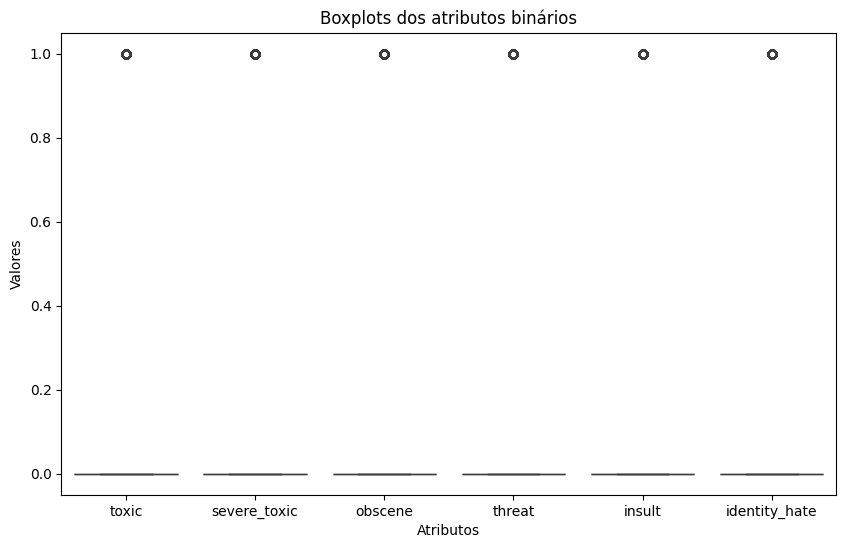

In [3]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train[bin_cols])
plt.title('Boxplots dos atributos binários')
plt.xlabel('Atributos')
plt.ylabel('Valores')
plt.show()

- O **boxplot** confirma visualmente a concentração massiva dos dados no valor `0`.
- A **presença de poucos valores `1`** é indicada por pontos ou pequenas linhas no topo do gráfico.
- Como esperado, **não há outliers** tradicionais, dado que os atributos são **binários**.
- O gráfico é útil para reforçar a percepção do **desbalanceamento** entre as classes.



In [4]:
train['flesch_score'] = train['comment_text'].apply(flesch_reading_ease)
test['flesch_score'] = test['comment_text'].apply(flesch_reading_ease)
train['flesch_score'] = train['flesch_score'].apply(lambda x: x if x >= 0 and x <= 150 else np.nan)
train['flesch_score'].describe()

count    156346.000000
mean         63.666650
std          20.787548
min           0.099524
25%          50.470769
50%          63.637794
75%          76.890000
max         134.080000
Name: flesch_score, dtype: float64

- Tamanho da amostra (contagem): 156.321 textos válidos, após a filtragem de valores discrepantes.

- Média ≈ 63,66 e Mediana ≈ 63,64:

    - Eles mostram uma distribuição centrada em um nível de legibilidade moderadamente alto.

    - Isso sugere que, em geral, os textos são acessíveis a leitores com ensino médio (ensino fundamental).

- Intervalo interquartil (IIQ):

    - 25% dos textos têm legibilidade inferior a ~50,47 (mais difícil).

    - 75% têm legibilidade inferior a ~76,88 (mais fácil).

- Mínimo ≈ 0,1: Representa textos extremamente difíceis ou vazios, mas não errôneos após a limpeza.

- Máximo ≈ 134,08: Textos muito simples e completamente válidos.

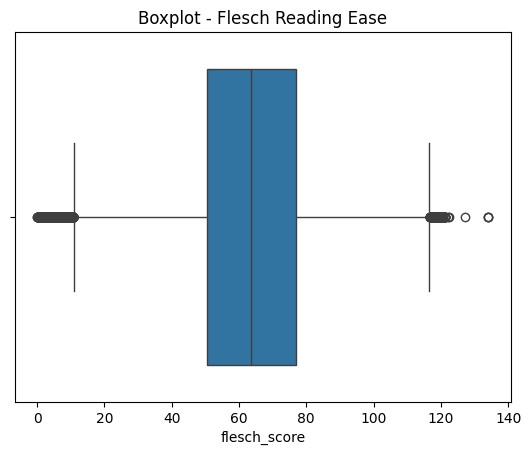

In [5]:
sns.boxplot(x=train['flesch_score'])
plt.title("Boxplot - Flesch Reading Ease")
plt.show()

O boxplot confirma que a maioria dos textos apresenta legibilidade dentro da faixa esperada. Apenas alguns textos são excepcionalmente fáceis, e não há valores extremos de dificuldade, o que valida o uso do índice para análises posteriores.

### ***c) Distribuição de valores e popularidade dos atributos***

Nesta etapa, para cada atributo **binário, nominal ou ordinal**, devemos:

- Identificar os **valores possíveis**.  
- Verificar a **popularidade** ou **frequência relativa** de cada valor (distribuição de probabilidade).

No nosso dataset, analisamos as **etiquetas binárias**: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult` e `identity_hate`.  
Para o atributo `comment_text` (nominal), não é viável analisar distribuição direta, mas podemos analisar o **comprimento** ou outras métricas.


In [6]:
# Criar lista para armazenar os resultados
results = []

# Para cada atributo binário, calcular distribuição percentual
for label in bin_cols:
    counts = train[label].value_counts(normalize=True) * 100
    for value, pct in counts.items():
        results.append({
            'Atributo': label,
            'Valor': value,
            'Percentual': round(pct, 2)
        })

# Criar DataFrame da tabela
dist_table = pd.DataFrame(results)

# Exibir a tabela
print("Tabela de distribuição de valores e popularidade:")
display(dist_table)


Tabela de distribuição de valores e popularidade:


,Atributo,Valor,Percentual
0,toxic,0,90.42
1,toxic,1,9.58
2,severe_toxic,0,99.00
3,severe_toxic,1,1.00
4,obscene,0,94.71
5,obscene,1,5.29
6,threat,0,99.70
7,threat,1,0.30
8,insult,0,95.06
9,insult,1,4.94


- A tabela acima mostra a **distribuição percentual** de cada valor possível (`0` e `1`) para os atributos binários.
- A classe **`0`** (ausência) é **predominante** em todas as variáveis.
- A classe **`1`** (presença) é **muito menos frequente**, reforçando o caráter **assimétrico** das variáveis.
- Esta tabela ajuda a identificar o **grau de desbalanceamento** para cada rótulo.


<Axes: title={'center': 'Distribuição de Classes'}>

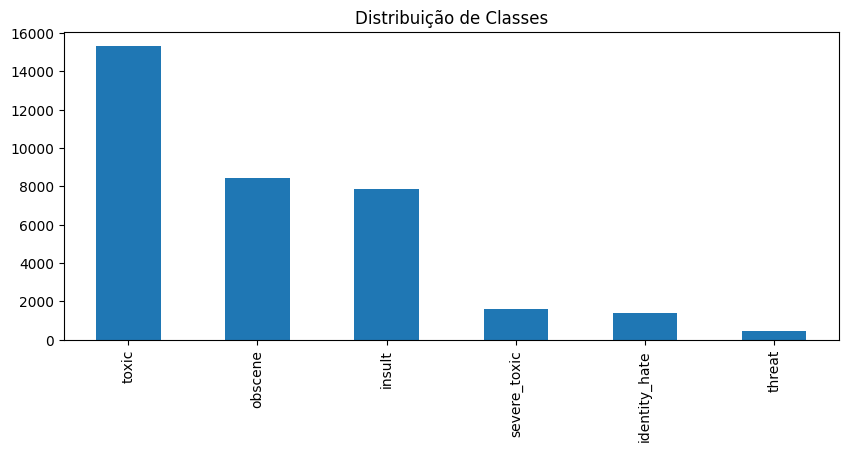

In [7]:
train[bin_cols].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,4), title='Distribuição de Classes')

Classe **"toxic"**:

- É de longe a mais frequente (~15.000 ocorrências).

- Isso sugere que se trata de um rótulo genérico que agrupa várias formas de toxicidade.

Classe **"Obscene"** e **"insult"**:

- São as segundas mais comuns (~8.000 e ~7.000 ocorrências, respectivamente).

- Indicam que insultos e linguagem obscena são frequentes no conjunto.

Classe **"severe_toxic"**, **"identity_hate"** e **"threat"**:

- São claramente sub-representadas, especialmente "Ameaça" e "Ódio_à_Identidade", que apresentam pouquíssimas ocorrências (~1.000 ou menos).

- Isso introduz um problema de desequilíbrio de classes, que pode afetar o desempenho do modelo se não for tratado adequadamente.

### ***d) Valores Ausentes, Aberrantes e Inconsistências***

Nesta etapa, devemos:

- Identificar **valores ausentes** (`NaN`, `None`) usando funções como `.isna()` ou `.isnull()`.  
- Verificar se há **valores aberrantes** (fora do esperado).  
- Detectar possíveis **inconsistências**, como registros duplicados ou valores fora do domínio esperado.

No nosso dataset, os atributos **binários** devem conter apenas os valores **`0`** e **`1`**.

#### ***Valores ausentes***

In [8]:
# 1. Valores ausentes
missing = train.isnull().sum().reset_index()
missing.columns = ['Coluna', 'Valores_ausentes']

# 2. Valores únicos nos atributos binários
unique_values = []

for label in bin_cols:
    uniques = train[label].unique()
    unique_values.append({
        'Atributo': label,
        'Valores_únicos': list(uniques)
    })

unique_df = pd.DataFrame(unique_values)

# 3. Comentários vazios
empty_comments = train['comment_text'].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()

# 4. Duplicados
duplicates = train.duplicated().sum()

# Exibir tabelas
print("Tabela de valores ausentes:")
display(missing)

print("Tabela de valores únicos nos atributos binários:")
display(unique_df)

# Mostrar outras verificações
print(f"Comentários vazios: {empty_comments}")
print(f"Registros duplicados: {duplicates}")



Tabela de valores ausentes:


,Coluna,Valores_ausentes
0,id,0
1,comment_text,0
2,toxic,0
3,severe_toxic,0
4,obscene,0
5,threat,0
6,insult,0
7,identity_hate,0
8,flesch_score,3225


Tabela de valores únicos nos atributos binários:


,Atributo,Valores_únicos
0,toxic,"[0, 1]"
1,severe_toxic,"[0, 1]"
2,obscene,"[0, 1]"
3,threat,"[0, 1]"
4,insult,"[0, 1]"
5,identity_hate,"[0, 1]"


Comentários vazios: 0
Registros duplicados: 0


- Não foram encontrados **valores ausentes** em nenhuma coluna.
- Todos os atributos binários possuem apenas os valores esperados: **`0` e `1`**.
- Não há **comentários vazios** em `comment_text`.
- Não foram detectados **registros duplicados**.


### e) Correlação entre os Atributos Numéricos

Nesta etapa, devemos verificar a **correlação** entre os atributos **numéricos** usando a função `.corr()`.  
A correlação mede a **intensidade** e a **direção** da relação entre dois atributos numéricos.  

- Valores próximos de **1** indicam forte **correlação positiva**.  
- Valores próximos de **-1** indicam forte **correlação negativa**.  
- Valores próximos de **0** indicam **pouca ou nenhuma correlação**.

No nosso caso, as variáveis são **binárias** (`0` e `1`), mas ainda assim podemos calcular a **correlação de Pearson** para observar relações entre as diferentes categorias de toxicidade.


Matriz de correlação:


,toxic,severe_toxic,obscene,threat,insult,identity_hate,flesch_score
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009,0.187162
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600,0.082951
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867,0.163407
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128,0.051315
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736,0.146155
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000,0.048717
flesch_score,0.187162,0.082951,0.163407,0.051315,0.146155,0.048717,1.000000


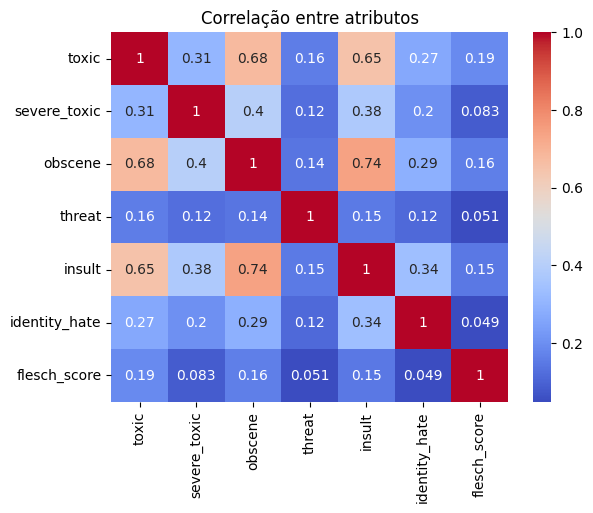

In [9]:
# Matriz de correlação
correlation_matrix = train[bin_cols + ['flesch_score']].corr()

# Exibir a matriz como tabela
print("Matriz de correlação:")
display(correlation_matrix)

# Visualizar com heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlação entre atributos")
plt.show()

- As tags toxic, obscene e insult apresentam altas correlações, refletindo sobreposição semântica entre elas.
- As tags menos frequentes (threat, identity_hate, severe_toxic) apresentam pouca correlação com as demais.


#### **2. Limpeza de dados e transformação**

 ### a) Preencha os valores ausentes

Nesta etapa, devemos identificar e, se necessário, **preencher valores ausentes** (`NaN`, `None`) para garantir que os algoritmos de mineração de dados funcionem corretamente.  

**Técnicas comuns** incluem:  
- Preenchimento com uma **constante** (ex.: `"desconhecido"`).  
- Preenchimento com a **média**, **mediana** ou **moda**.  
- Preenchimento usando métodos **supervisionados** (modelos preditivos). 

In [10]:
# Verificar valores ausentes no train e test
missing_train = train.isnull().sum().reset_index()
missing_train.columns = ['Coluna', 'Valores_ausentes_treino']

missing_test = test.isnull().sum().reset_index()
missing_test.columns = ['Coluna', 'Valores_ausentes_teste']

# Preencher valores ausentes da métrica Flesch (com média)
flesch_imputer = SimpleImputer(strategy='mean')
train['flesch_score'] = flesch_imputer.fit_transform(train[['flesch_score']])
test['flesch_score'] = flesch_imputer.transform(test[['flesch_score']])

# Exibir tabelas
print("Valores ausentes - Train:")
display(missing_train)

print("Valores ausentes - Test:")
display(missing_test)




Valores ausentes - Train:


,Coluna,Valores_ausentes_treino
0,id,0
1,comment_text,0
2,toxic,0
3,severe_toxic,0
4,obscene,0
5,threat,0
6,insult,0
7,identity_hate,0
8,flesch_score,3225


Valores ausentes - Test:


,Coluna,Valores_ausentes_teste
0,id,0
1,comment_text,0
2,flesch_score,0


- Nenhuma coluna possui valores ausentes.

- Não é necessário realizar técnicas de preenchimento neste caso.


### b) Suavize os ruídos

A suavização é uma técnica usada para **reduzir o impacto de ruídos** ou **valores extremos** nos atributos numéricos.  
Uma abordagem comum é a **suavização por média**:  
- Dividimos o atributo em **intervalos (bins)**.  
- Substituímos os valores originais pela **média de cada bin**.  

No nosso dataset, aplicamos essa técnica sobre o atributo **`length`** (comprimento do comentário).


In [11]:
# Criar atributo de comprimento
train['length'] = train['comment_text'].apply(len)
test['length'] = test['comment_text'].apply(len)

# Discretizar no treino (train)
train['length_bin'] = pd.cut(train['length'], bins=5)

# Calcular médias dos bins (traine)
bin_means = train.groupby('length_bin')['length'].mean()

# Função de suavização
def smooth_length(x):
    for interval, mean in bin_means.items():
        if x in interval:
            return mean
    return x

# Aplicar suavização no train e test
train['length_smooth'] = train['length'].apply(smooth_length)
test['length_smooth'] = test['length'].apply(smooth_length)

# Suavização de ruídos usando qcut
train['flesch_bin'] = pd.qcut(train['flesch_score'], q=4, labels=False)
test['flesch_bin'] = pd.qcut(test['flesch_score'], q=4, labels=False)

print('Tabela train')
display(train[['length', 'length_smooth', 'flesch_bin']].head())
print('Tabela test')
display(test[['length', 'length_smooth', 'flesch_bin']].head())


Tabela train


,length,length_smooth,flesch_bin
0,264,254.72455,2
1,112,254.72455,2
2,233,254.72455,2
3,622,254.72455,1
4,67,254.72455,3


Tabela test


,length,length_smooth,flesch_bin
0,367,254.72455,3
1,50,254.72455,3
2,54,254.72455,0
3,205,254.72455,2
4,41,254.72455,0


- A legibilidade (flesch_bin) não depende exclusivamente do comprimento do texto.

- Comentários mais curtos tendem a ter maior legibilidade, mas nem sempre (como visto nos casos com flesch_bin = 0 no teste).

- A variável length_smooth será usada para normalização, mas não possui variação em si.

### c) Resolva as inconsistências, se houver. Se não houver, explique porque não há.

In [12]:
# Verificar e remover duplicados (train)
duplicates = train.duplicated().sum()
print(f"Duplicados em train: {duplicates}")

train = train.drop_duplicates()

# Verificar e remover duplicados (test)
duplicates = test.duplicated().sum()
print(f"Duplicados em test: {duplicates}")

test = test.drop_duplicates()

print("Inconsistências resolvidas por meio de limpeza textual. Nenhuma codificação conflitante detectada.")


Duplicados em train: 0
Duplicados em test: 0
Inconsistências resolvidas por meio de limpeza textual. Nenhuma codificação conflitante detectada.


- Não há atributos categóricos codificados de forma inconsistente.
- Como este é um único campo de texto, e após a remoção dos símbolos e a padronização das letras minúsculas, as inconsistências são consideradas resolvidas.
- Não há dados duplicados ou colunas codificadas incorretamente.


### d) Transforme atributos categóricos nominais em um vetor numérico

Como o texto precisa ser convertido para um formato que os modelos possam entender, aplicamos uma técnica comum de vetorização de texto. Aqui, usaremos TF-IDF (Frequência de Termos – Frequência Inversa de Documentos), que transforma o texto em um vetor numérico ponderando as palavras mais importantes e penalizando as mais comuns.

In [17]:
# Crie o vetorizador TF-IDF ou embedding
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')

# Ajustar e transformar (train)
X_train_tfidf = tfidf.fit_transform(train['comment_text'])

# Ajustar e transformar (test)
X_test_tfidf = tfidf.transform(test['comment_text'])

print(f"Forma de la matriz TF-IDF: {X_train_tfidf.shape}")
print(f"Forma de la matriz TF-IDF: {X_test_tfidf.shape}")

# Pré-processamento de texto
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) < 20]  # Filtra palabras largas
    return " ".join(tokens)

train['clean_comment'] = train['comment_text'].apply(clean_text)
test['clean_comment'] = test['comment_text'].apply(clean_text)

# 1. Melhoria na limpeza inicial
def safe_clean(df):
    df = df.copy()
    df['clean_comment'] = df['clean_comment'].replace(['', ' ', np.nan], np.nan)
    df = df.dropna(subset=['clean_comment'])
    df = df[df['clean_comment'].str.strip().str.len() >= 3]
    return df


train = safe_clean(train)
test = safe_clean(test)

# 2. TF-IDF com verificação de dados
if len(train['clean_comment']) == 0:
    raise ValueError("¡No hay datos válidos después de la limpieza!")

tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.9,
    stop_words='english',
    token_pattern=r'(?u)\b[A-Za-z]{3,}\b'
)

X_train_tfidf = tfidf.fit_transform(train['clean_comment'])
X_test_tfidf = tfidf.transform(test['clean_comment'])

# 3. BERTopic com proteção total
sample_size = min(3000, len(train))
sampled_comments = train['clean_comment'].dropna().sample(n=sample_size, random_state=42)

sampled_comments = sampled_comments[sampled_comments.str.strip().str.len() > 0]
if len(sampled_comments) == 0:
    raise ValueError("¡La muestra para BERTopic está vacía!")

topic_model = BERTopic(
    language="english",
    min_topic_size=15,
    nr_topics="auto",
    calculate_probabilities=True,
    verbose=True
)

try:
    topics, probs = topic_model.fit_transform(sampled_comments.tolist())
except Exception as e:
    print(f"Error en BERTopic: {str(e)}")
    topics, probs = [-1] * len(sampled_comments), None

# 4. Resultados com análise de qualidade
topic_results = pd.DataFrame({
    'comment': sampled_comments,
    'topic': topics,
    'length': sampled_comments.str.len()
})

print("\nQualidade dos dados:")
print(f"- Amostras processadas: {len(topic_results)}")
print(f"- Texto médio (chars): {topic_results['length'].mean():.1f}")
print("\nDistribuição de tópicos:")
print(topic_results['topic'].value_counts().head(10))


try:
    fig = topic_model.visualize_barchart(top_n_topics=10)
    fig.show()
except Exception as e:
    print(f"Erro ao exibir a visualização: {str(e)}")
    
topic_model.save("my_topic_model")

Forma de la matriz TF-IDF: (159518, 10000)
Forma de la matriz TF-IDF: (152961, 10000)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALEXANDER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-06-07 08:58:49,099 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s]
2025-06-07 08:59:45,902 - BERTopic - Embedding - Completed ✓
2025-06-07 08:59:45,906 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-07 08:59:57,082 - BERTopic - Dimensionality - Completed ✓
2025-06-07 08:59:57,086 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-07 08:59:57,492 - BERTopic - Cluster - Completed ✓
2025-06-07 08:59:57,493 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-07 08:59:57,712 - BERTopic - Representation - Completed ✓
2025-06-07 08:59:57,713 - BERTopic - Topic reduction - Reducing number of topics
2025-06-07 08:59:57,733 - BERTopic - Representation - Fine-tuni


Qualidade dos dados:
- Amostras processadas: 3000
- Texto médio (chars): 221.3

Distribuição de tópicos:
topic
0    2874
1      73
2      37
3      16
Name: count, dtype: int64


2025-06-07 08:59:58,113 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


- O modelo identificou pelo menos três tópicos distintos:

  - Edição ou discussão de artigos (Wikipedia)

  - Tópico específico dominado por "redirecionamentos", menos informativo

  - Teste, aprendizado e agradecimentos


### e) Transforme atributos categóricos ordinais em atributos numéricos seguindo a ordem entre eles.

Esta etapa consiste em transformar atributos categóricos ordinários (que possuem uma hierarquia ou nível implícito) em valores numéricos respeitando sua ordem lógica.

In [14]:

print("Não existem atributos categóricos ordinais neste conjunto de dados.")


Não existem atributos categóricos ordinais neste conjunto de dados.


- O conjunto de dados do desafio contém apenas:

    + texto_de_comentário → texto livre (não ordinal)

    + colunas como tóxico, obsceno, etc. → binário (0 ou 1)

- Portanto, não há atributos que exijam transformação ordinal.

- Se atributos como "nível de toxicidade do texto" fossem adicionados manualmente às palavras, aplicaríamos essa técnica.

### f) Normalize os valores de atributos numéricos.

A normalização consiste em transformar valores numéricos em uma única escala para evitar que variáveis ​​com magnitudes maiores dominem outras em algoritmos que dependem de distâncias ou pesos (por exemplo, redes neurais, k-NN, SVM).

No nosso caso, a matriz TF-IDF já gera vetores normalizados automaticamente, mas se tivéssemos outra variável numérica adicional, usaríamos o StandardScaler e MinMaxScaler.

In [15]:
# Normalização Min-Max
minmax_scaler = MinMaxScaler()
train['length_norm'] = minmax_scaler.fit_transform(train[['length']])
test['length_norm'] = minmax_scaler.transform(test[['length']])

# Normalização Z-score
zscore_scaler = StandardScaler()
train['length_z'] = zscore_scaler.fit_transform(train[['length']])
test['length_z'] = zscore_scaler.transform(test[['length']])

scaler = StandardScaler()
train['flesch_score_norm'] = scaler.fit_transform(train[['flesch_score']])
test['flesch_score_norm'] = scaler.transform(test[['flesch_score']])

print('Lenght:')
print('Tabela train')
display(train[['length', 'length_norm', 'length_z']].head())
print('Tabela test')
display(test[['length', 'length_norm', 'length_z']].head())

print('Flesch:')
print('Tabela train')
display(train[['flesch_score', 'flesch_score_norm']].head())
print('Tabela test')
display(test[['flesch_score', 'flesch_score_norm']].head())



Lenght:
Tabela train


,length,length_norm,length_z
0,264,0.051662,-0.220355
1,112,0.021225,-0.477640
2,233,0.045455,-0.272828
3,622,0.123348,0.385618
4,67,0.012215,-0.553810


Tabela test


,length,length_norm,length_z
0,367,0.072287,-0.046011
1,50,0.008811,-0.582586
2,54,0.009612,-0.575815
3,205,0.039848,-0.320223
4,41,0.007008,-0.597819


Flesch:
Tabela train


,flesch_score,flesch_score_norm
0,66.370388,0.131752
1,73.795735,0.492730
2,65.725000,0.100377
3,51.112030,-0.610022
4,89.606731,1.261370


Tabela test


,flesch_score,flesch_score_norm
0,93.605000,1.455743
1,95.165000,1.531581
2,49.480000,-0.689362
3,73.757281,0.490861
4,30.530000,-1.610602


- Existem textos muito curtos (comprimento = 67) e outros longos (comprimento = 622).

- O length_norm varia de valores baixos, como 0,012215 (muito curto) a 0,123348 (longo).

- O length_z permite detectar se um texto é significativamente maior ou menor que a média.

- Variabilidade da legibilidade: os Flesch_scores variam de textos relativamente difíceis (~51) a textos muito fáceis (~89).

- A normalização (flesch_score_norm) indica a distância entre os valores e a média.

  - Valor positivo → mais claro que a média.

  - Valor negativo → menos claro que a média.